In [1]:
# Import essential packages
import wntr
import pickle
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#from sklearn.neighbors import KernelDensity
#from sklearn.model_selection import GridSearchCV

In [2]:
# "the default sans-serif font is Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14})

In [92]:
OWdn = wntr.network.WaterNetworkModel(r'CoH_460MGD_2018.inp')
BWdn = wntr.network.WaterNetworkModel(r'CoH_Backbone_Final_O.inp')

In [93]:
OWdn.options.time.duration = 8 * 3600
OSim = wntr.sim.EpanetSimulator(OWdn)
OResults = OSim.run_sim()

In [94]:
BWdn.options.time.duration = 1 * 3600
BSim = wntr.sim.EpanetSimulator(BWdn)
BResults = BSim.run_sim()

### The pressure

In [95]:
OPressure = OResults.node['pressure']
BPressure = BResults.node['pressure']

In [7]:
def mapnodeattribute(wdn, attribute, junctionlist, time):
    nodeattribute = []
    dx = []
    dy = []
    for node in junctionlist:
        # Get its demand
        value = attribute.loc[time*3600, node]
        nodeobject = wdn.get_node(node)
        nodeattribute.append(value)
        (x, y) = nodeobject.coordinates
        dx.append(x)
        dy.append(y)
    nodeattribute = np.array(nodeattribute)
    return nodeattribute, dx, dy

In [96]:
Junctionlist = BWdn.junction_name_list

In [97]:
Demand = BResults.node['demand']

In [98]:
Junction_demand = {}
for j in Junctionlist:
    Junction_demand[j] = Demand.loc[3600*1, j]
print(sum(Junction_demand.values()))

20.774094356184264


In [99]:
OT = 7
ONodepressure, Dx, Dy = mapnodeattribute(BWdn, OPressure, Junctionlist, OT)

In [100]:
BT = 1
BNodepressure, Dx, Dy = mapnodeattribute(BWdn, BPressure, Junctionlist, BT)

In [13]:
def get_node_coordinate(wdn, node_list):
    node_x = []
    node_y = []
    for node in node_list:
        nodeobject = wdn.get_node(node)
        (x, y) = nodeobject.coordinates
        node_x.append(x)
        node_y.append(y)
    return node_x, node_y

In [14]:
# The three WTPs
WTPs = ['4027_1', '4027_2', '4027_3']
# The real underground treatment plants
Groundwells = ['3988', '3990', '3992', '3997', '3999', '4002', '4004', '4007', '4009', '4012', '4017', '4019', '4020', '4021', '4022', '4025']
# Get their location
W_x, W_y = get_node_coordinate(OWdn, WTPs)
G_x, G_y = get_node_coordinate(OWdn, Groundwells)
DPRPX = []
DPRPY = []
DPRdata = pd.read_csv('DPR_site.csv', index_col=0)
for index, row in DPRdata.iterrows():
    DPRPX.append(row['P_X'])
    DPRPY.append(row['P_Y'])

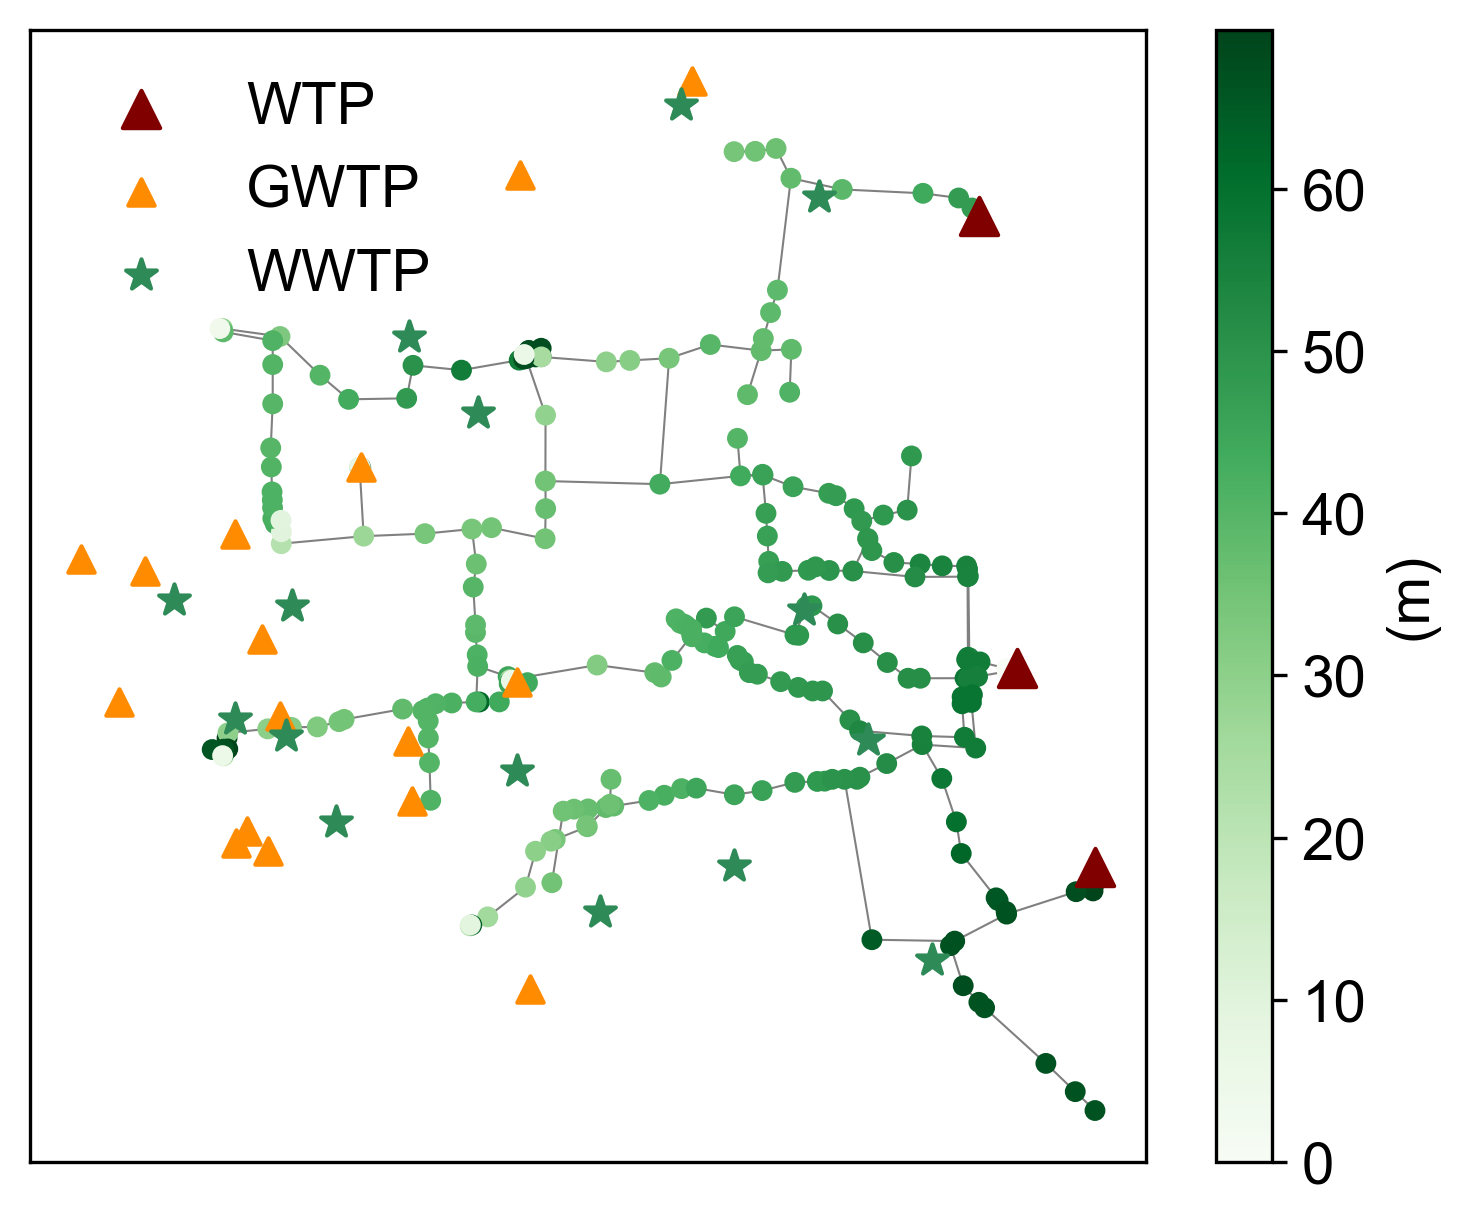

In [102]:
# Visualize the results
# Draw the whole network
G = BWdn.get_graph()
POS = nx.get_node_attributes(G,'pos')
nx.draw_networkx(G, pos=POS, arrows=False, with_labels=False, node_color='gray',
                 node_size = 0, width = 0.5, edge_color='gray')
# Make the corlor mapp
Vmin = np.min(BNodepressure)
Vmax = np.max(BNodepressure)
plt.scatter(Dx, Dy, s = 16, c = BNodepressure, cmap = 'Greens', vmin = 0, vmax = Vmax) # Purples
plt.scatter(W_x, W_y, marker = "^", s = 80, c = 'maroon', label = 'WTP')
plt.scatter(G_x, G_y, marker = "^", s = 40, c = 'darkorange', label = 'GWTP')
plt.scatter(DPRPX, DPRPY, marker = "*", s = 60, c = 'seagreen', label = 'WWTP')
# Make the legend
plt.legend(frameon=False, loc = 'upper left')
Sm1 = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0, vmax = Vmax))
Sm1.set_array([])
plt.xticks([])
plt.yticks([])
cbar1 = plt.colorbar(Sm1, label='(m)')
plt.rcParams['figure.figsize'] = (6, 5) 
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 
plt.savefig(r"CoH_Backbone_Node_Pressure.jpg", bbox_inches='tight')
plt.show()

In [17]:
# Get the percent of change at the backbone nodes
def get_relativeerror(bnodepressure, onodepressure):
    relativeerror = []
    for k in range(len(bnodepressure)):
        bk = bnodepressure[k]
        ok = onodepressure[k]
        # As for nodes that have very small pressure
        if ok < 1:
            relativeerror.append(0)
        else:
            relativeerror.append( (bk-ok)*100/ok )
    relativeerror = np.array(relativeerror)
    return relativeerror 

In [103]:
Relativeerror = get_relativeerror(BNodepressure, ONodepressure)

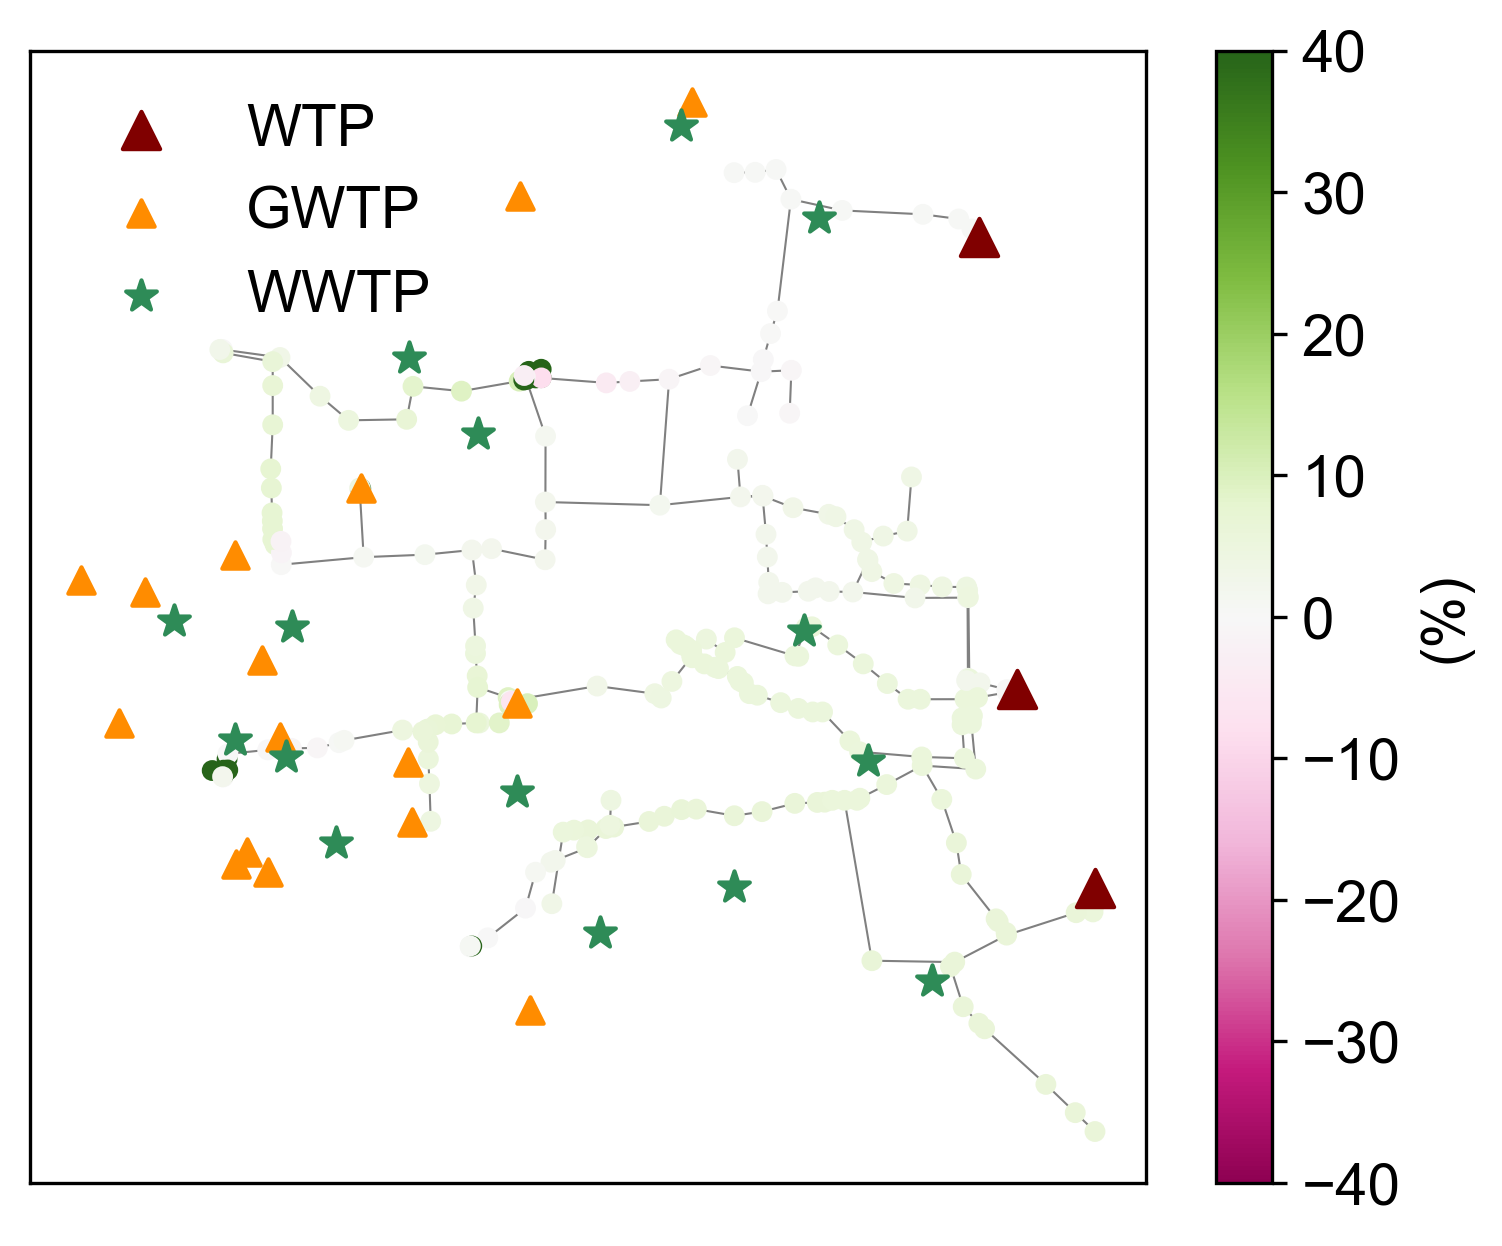

In [104]:
# Visualize the results
# Draw the whole network
G = BWdn.get_graph()
POS = nx.get_node_attributes(G,'pos')
nx.draw_networkx(G, pos=POS, arrows=False, with_labels=False, node_color='gray',
                 node_size = 0, width = 0.5, edge_color='gray')
# Make the corlor mapp
Vmin = np.min(Relativeerror)
Vmax = np.max(Relativeerror)
plt.scatter(Dx, Dy, s = 16, c = Relativeerror, cmap = 'PiYG', vmin = -40, vmax = 40)
plt.scatter(W_x, W_y, marker = "^", s = 80, c = 'maroon', label = 'WTP')
plt.scatter(G_x, G_y, marker = "^", s = 40, c = 'darkorange', label = 'GWTP')
plt.scatter(DPRPX, DPRPY, marker = "*", s = 60, c = 'seagreen', label = 'WWTP')
# Make the legend
plt.legend(frameon=False, loc = 'upper left')
Sm1 = plt.cm.ScalarMappable(cmap='PiYG', norm=plt.Normalize(vmin = -40, vmax = 40))
Sm1.set_array([])
plt.xticks([])
plt.yticks([])
cbar1 = plt.colorbar(Sm1, label='(%)')
plt.rcParams['figure.figsize'] = (6, 5) 
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 
plt.savefig(r"CoH_Relativeerror_Node_Pressure.jpg", bbox_inches='tight')
plt.show()

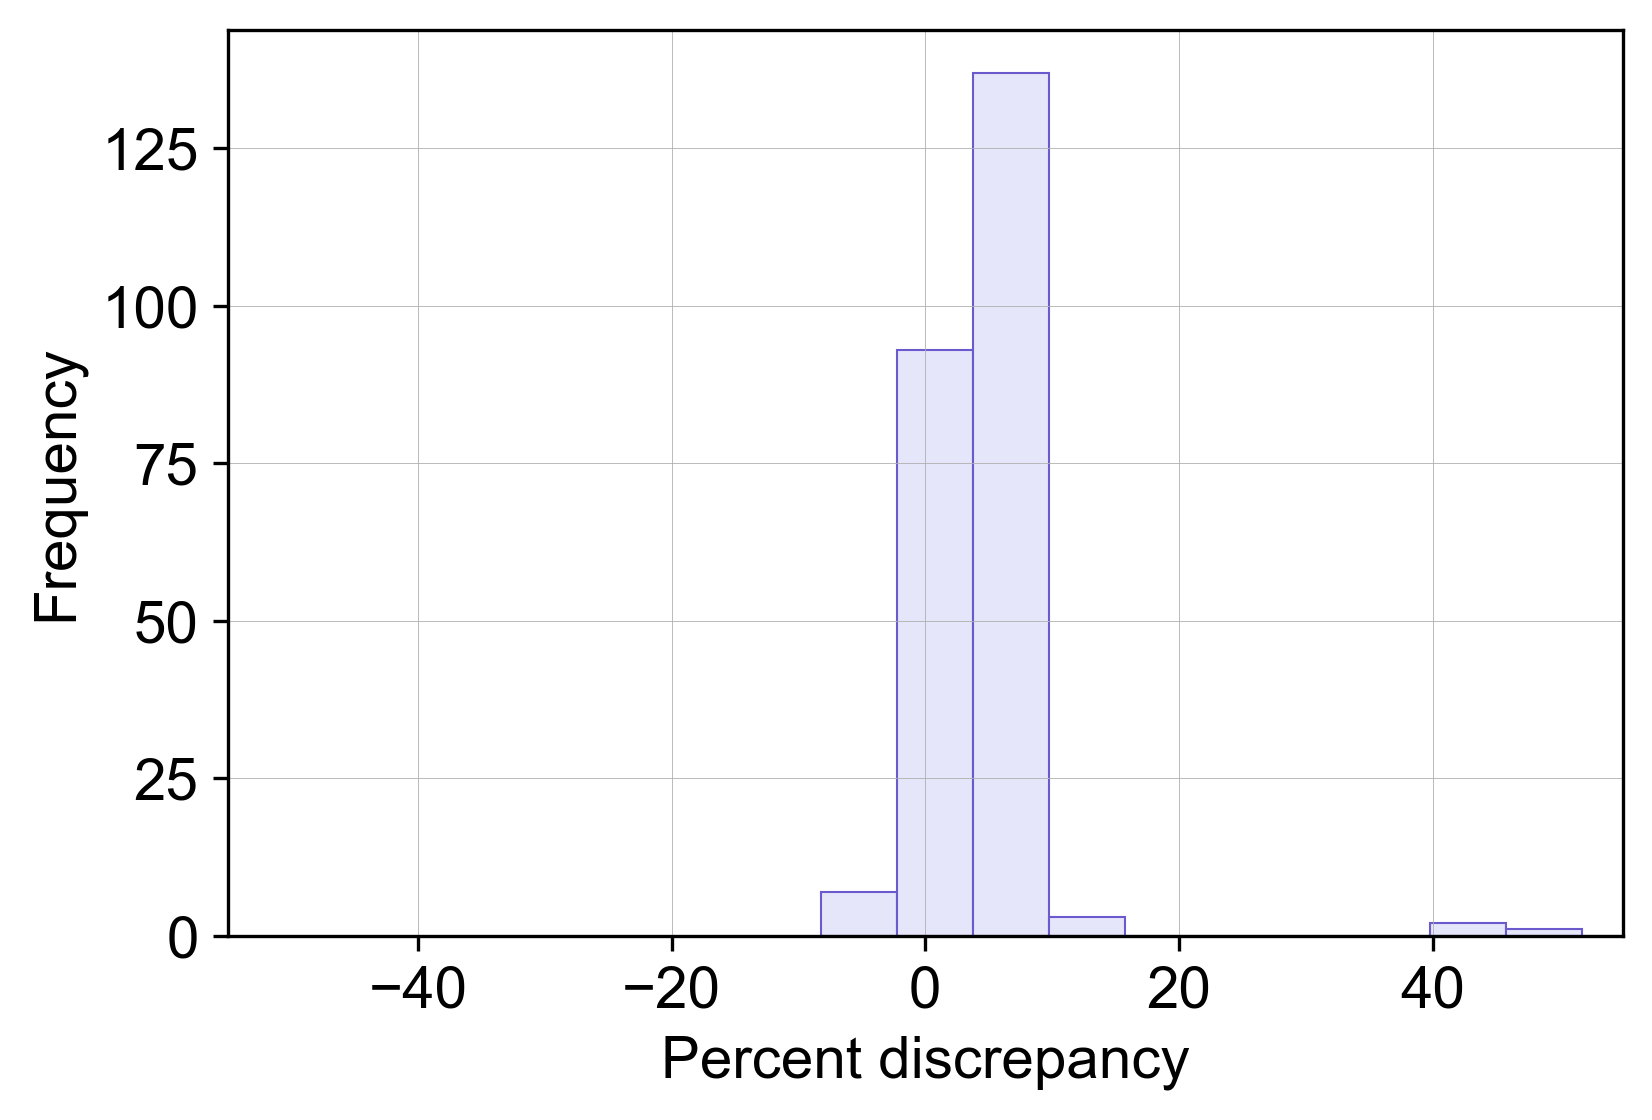

In [106]:
# Visualize the distribution of relativeerror
plt.hist(Relativeerror, bins=20, facecolor = 'lavender', edgecolor='slateblue', linewidth=0.5)
plt.xlim(-55, 55)
plt.xlabel('Percent discrepancy')
plt.ylabel('Frequency')
plt.grid(linewidth=0.2)
plt.rcParams['figure.figsize'] = (6, 4) 
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 
plt.savefig(r"CoH_Relative_pressure_distribution.jpg", bbox_inches='tight')
plt.show()

### Compare the flow condition

In [78]:
def get_supply(sources, wdn, flow, t):
    source_link = {}
    supply = 0
    for name, link in wdn.links():
        s = link.start_node_name
        if s in sources:
            supply += flow.loc[t*3600, name]    
    return supply

In [79]:
OFlow = OResults.link['flowrate']

In [107]:
BFlow = BResults.link['flowrate']

In [110]:
Sources = ['4027_3']
Supply = get_supply(Sources, BWdn, BFlow, BT)
Supply

11.79106616973877

In [88]:
print((2.156-2.140)/2.140)

0.007476635514018698


In [89]:
print((11.167+5.312+2.140) )

18.619


In [90]:
print(11.788+5.366+2.158)

19.312


In [91]:
print((19.312-18.619)/18.619)

0.03722004404103343


In [112]:
print(0.9450+0.7890+0.1800+0.3380+0.6657)

2.9177


In [1]:
a = 'er'
print(a[0])

e
